In [30]:
import os
import random

import cv2
import albumentations as A
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm, trange

In [31]:
# randomness 제어를 위한 시드 고정 (학습 결과 재현을 위해 고정)
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.cuda.empty_cache()


# 시드 값 선택
SEED = 42
set_seed(SEED)

# 학습 장치 결정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [32]:
# ##### tqdm 사용법 #####
# import time

# # trange
# for i in trange(100):
#     time.sleep(0.01)

# # tqdm
# for _ in tqdm(list(range(100))): 
#     time.sleep(0.01)
    
# # iterable 객체는 모두 사용 가능, zip()이나 enumerate()와 같이 __len__()이 없는 경우 total=len(a)와 같이 명시
# for _ in tqdm(zip(list(range(100)), list(range(100))), total=len(range(100))):
#     time.sleep(0.01)

# # 이중 반복문에서 사용
# for _ in tqdm(list(range(5))):
#     for _ in tqdm(list(range(100))):
#         time.sleep(0.01)

## Data Preprocessing

In [33]:
# 경로 설정 (로컬 환경인 경우 자신의 경로로 설정)
root_dir = '/kaggle/input/2024-dl-final/'
save_dir = '/kaggle/working/'

train_dir = root_dir + 'train/'
train_w2v_dir = root_dir + 'train_w2v/'
test_dir = root_dir + 'test/'
test_w2v_dir = root_dir + 'test_w2v/'

In [34]:
train_df = pd.read_csv(root_dir + 'train.csv')
test_df = pd.read_csv(root_dir + 'test.csv')

In [35]:
train_df.head(5)

,id,path,w2v_path,title,year,genres
0,13,/kaggle/input/2024-dl-final/train/13.jpg,/kaggle/input/2024-dl-final/train_w2v/13.npy,Forrest Gump,1994,"['Comedy', 'Drama', 'Romance']"
1,55,/kaggle/input/2024-dl-final/train/55.jpg,/kaggle/input/2024-dl-final/train_w2v/55.npy,Amores Perros,2000,"['Drama', 'Thriller']"
2,64,/kaggle/input/2024-dl-final/train/64.jpg,/kaggle/input/2024-dl-final/train_w2v/64.npy,Talk to Her,2002,"['Drama', 'Romance']"
3,80,/kaggle/input/2024-dl-final/train/80.jpg,/kaggle/input/2024-dl-final/train_w2v/80.npy,Before Sunset,2004,"['Drama', 'Romance']"
4,86,/kaggle/input/2024-dl-final/train/86.jpg,/kaggle/input/2024-dl-final/train_w2v/86.npy,The Elementary Particles,2006,"['Drama', 'Romance']"


In [36]:
test_df.head(5)

,id,path,w2v_path,title,year
0,32,/kaggle/input/2024-dl-final/test/32.jpg,/kaggle/input/2024-dl-final/test_w2v/32.npy,Cannon Fodder,1995
1,91,/kaggle/input/2024-dl-final/test/91.jpg,/kaggle/input/2024-dl-final/test_w2v/91.npy,Land Without Bread,1933
2,114,/kaggle/input/2024-dl-final/test/114.jpg,/kaggle/input/2024-dl-final/test_w2v/114.npy,Pretty Woman,1990
3,142,/kaggle/input/2024-dl-final/test/142.jpg,/kaggle/input/2024-dl-final/test_w2v/142.npy,Brokeback Mountain,2005
4,156,/kaggle/input/2024-dl-final/test/156.jpg,/kaggle/input/2024-dl-final/test_w2v/156.npy,Wilbur Wants to Kill Himself,2002


In [37]:
# str -> list 변환 ("['Romance', 'Action', ...]" -> ['Romance', 'Action', ...])
train_df['genres'] = train_df['genres'].apply(lambda x: eval(x))

# multi label encoding
mlb = MultiLabelBinarizer()
train_label = mlb.fit_transform(train_df['genres'])

# column 순서 확인
mlb.classes_

array(['Action', 'Animation', 'Comedy', 'Documentary', 'Drama', 'Horror',
       'Romance', 'Thriller'], dtype=object)

In [38]:
# 기존 데이터와 결합
mlb_train = pd.DataFrame(train_label, columns=mlb.classes_)

train_df = pd.concat([train_df, mlb_train], axis=1)
train_df.head()

,id,path,w2v_path,title,year,genres,Action,Animation,Comedy,Documentary,Drama,Horror,Romance,Thriller
0,13,/kaggle/input/2024-dl-final/train/13.jpg,/kaggle/input/2024-dl-final/train_w2v/13.npy,Forrest Gump,1994,"[Comedy, Drama, Romance]",0,0,1,0,1,0,1,0
1,55,/kaggle/input/2024-dl-final/train/55.jpg,/kaggle/input/2024-dl-final/train_w2v/55.npy,Amores Perros,2000,"[Drama, Thriller]",0,0,0,0,1,0,0,1
2,64,/kaggle/input/2024-dl-final/train/64.jpg,/kaggle/input/2024-dl-final/train_w2v/64.npy,Talk to Her,2002,"[Drama, Romance]",0,0,0,0,1,0,1,0
3,80,/kaggle/input/2024-dl-final/train/80.jpg,/kaggle/input/2024-dl-final/train_w2v/80.npy,Before Sunset,2004,"[Drama, Romance]",0,0,0,0,1,0,1,0
4,86,/kaggle/input/2024-dl-final/train/86.jpg,/kaggle/input/2024-dl-final/train_w2v/86.npy,The Elementary Particles,2006,"[Drama, Romance]",0,0,0,0,1,0,1,0


In [39]:
# # 로컬 환경에서 학습하는 경우
# train_df['path'] = train_df['path'].apply(lambda x: train_dir + x.split('/')[-1])
# test_df['path'] = test_df['path'].apply(lambda x: test_dir + x.split('/')[-1])
# train_df['w2v_path'] = train_df['w2v_path'].apply(lambda x: train_w2v_dir + x.split('/')[-1])
# test_df['w2v_path'] = test_df['w2v_path'].apply(lambda x: test_w2v_dir + x.split('/')[-1])

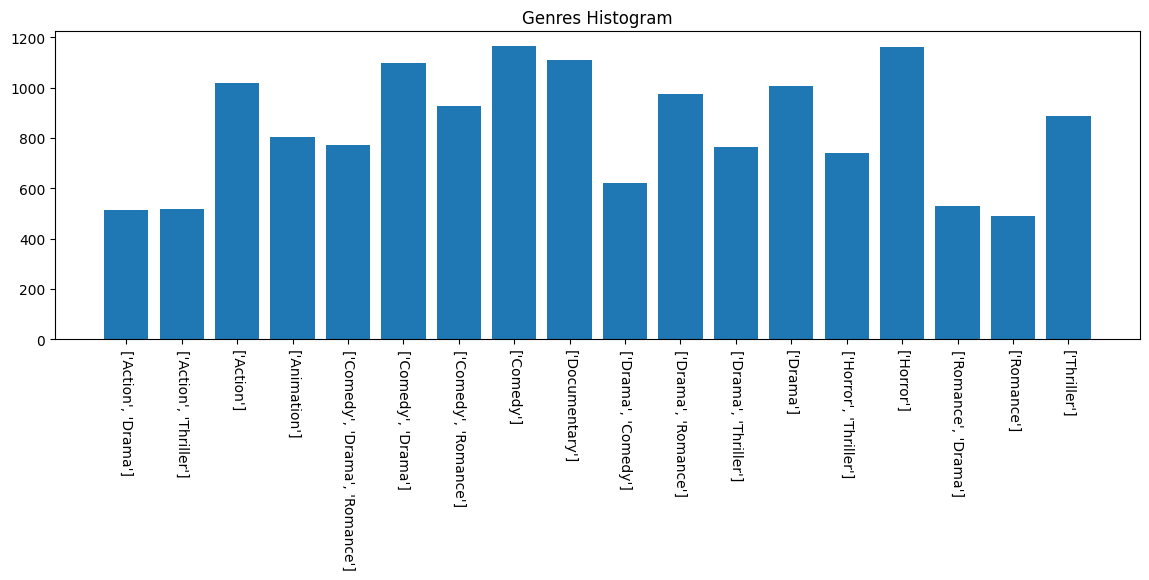

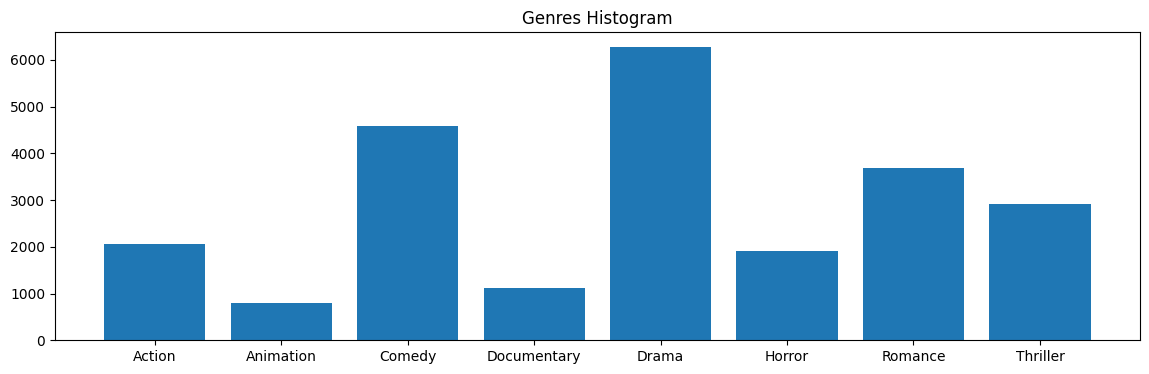

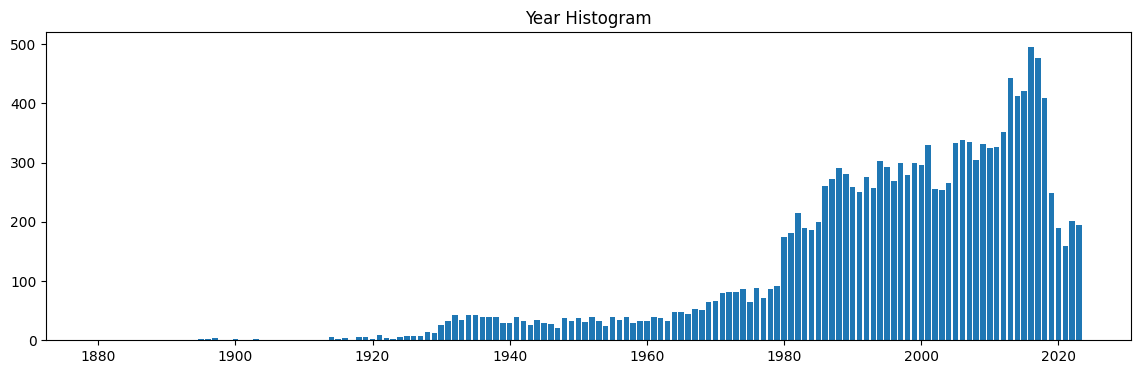

In [40]:
# multi-label을 하나의 class로 보는 경우의 히스토그램
tr_hist = train_df['genres'].apply(lambda x: str(x)).sort_values()
plt.figure(figsize=(14, 4))
plt.bar(tr_hist.unique(), tr_hist.value_counts().sort_index())
plt.xticks(rotation=-90)
plt.title('Genres Histogram')
plt.show()

# single-label을 하나의 class로 보는 경우의 히스토그램
mlb_hist = mlb_train.sum(axis=0)
plt.figure(figsize=(14, 4))
plt.bar(mlb.classes_, mlb_hist)
plt.title('Genres Histogram')
plt.show()


# 연도별 영화 히스토그램
plt.figure(figsize=(14, 4))
plt.bar(train_df['year'].sort_values().unique(), train_df['year'].value_counts().sort_index())
plt.title('Year Histogram')
plt.show()

## Dataset & Dataloader

In [41]:
class MovieDataset(Dataset):
    def __init__(self, df, transform=None, mode='train'):
        self.df = df
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 이미지 처리
        image = cv2.cvtColor(cv2.imread(self.df.iloc[idx, 1]), cv2.COLOR_BGR2RGB)
        w2v = torch.Tensor(np.load(self.df.iloc[idx, 2]))  # Word2Vec 벡터

        # 이미지 변환
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        else:
            image = A.ToTensorV2()(image=image)

        # Word2Vec 정규화
        w2v = (w2v - w2v.mean()) / (w2v.std() + 1e-6)

        if self.mode == 'train':
            label = torch.Tensor(self.df.iloc[idx, 6:].to_numpy(dtype=np.float32))
            return image, w2v, label

        return image, w2v

In [42]:
# 학습용 데이터 증강 (transform)
train_transform = A.Compose([
    A.Resize(224, 224),  # 이미지를 224x224 크기로 조정
    A.RandomBrightnessContrast(p=0.2),  # 밝기와 대비 랜덤 조정 (20% 확률)
    A.HorizontalFlip(p=0.5),  # 이미지 수평 뒤집기 (50% 확률)
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),  # 이동, 확대/축소, 회전 적용 (50% 확률)
    A.Normalize(),  # 픽셀 값 정규화 (mean=0, std=1 범위)
    A.CoarseDropout(
        max_holes=3,        # 최대 지울 영역 개수 (3개)
        max_height=40,      # 최대 지울 영역 높이 (40)
        max_width=40,       # 최대 지울 영역 너비 (40)
        min_holes=1,        # 최소 지울 영역 개수 (1개)
        min_height=20,      # 최소 지울 영역 높이 (20)
        min_width=20,       # 최소 지울 영역 너비 (20)
        fill_value=0,       # 지운 영역을 검은색(0)으로 채움
        p=1.0               # 적용 확률 (1.0 = 항상 적용)
    ),

    # 이미지를 PyTorch Tensor로 변환하고 
    # 순서를 (H, W, C) → (C, H, W)로 변경
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(224, 224),  # 이미지를 224x224 크기로 조정
    A.Normalize(),       # 픽셀 값 정규화
    ToTensorV2()         # 텐서로 변환
])

In [43]:
batch_size = 128
num_workers = 0  # kaggle에서 학습하는 경우 최대 2까지 설정

# train/validation 분리
train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=SEED,
                                    stratify=train_df['genres'])

train_dataset = MovieDataset(df=train_df, transform=train_transform)
val_dataset = MovieDataset(df=val_df, transform=test_transform)
test_dataset = MovieDataset(df=test_df, transform=test_transform, mode='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

train_dataset.__len__(), val_dataset.__len__(), test_dataset.__len__()

(12080, 3021, 5034)

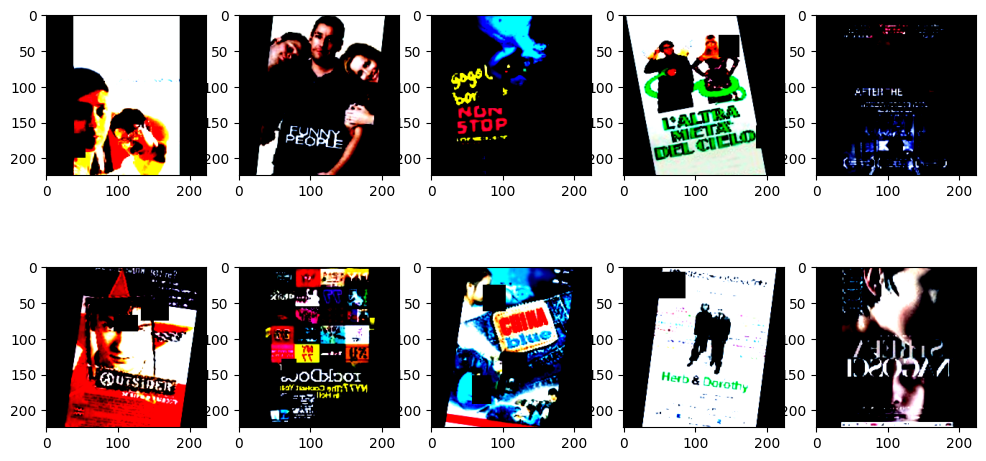

In [44]:
imgs = []
for i in range(10):
    img, _, _ = train_dataset.__getitem__(i)  # transform이 적용된 이미지 반환
    img = img.permute((1, 2, 0)).float()
    imgs.append(img.numpy())  # (3, 128, 128) 형태의 image를 (128, 128, 3) 형태로 바꿔서 저장

fig = plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i])

plt.show()

## Model

In [45]:
class MovieClassifier(nn.Module):
    def __init__(self, num_classes, hidden_size):
        super(MovieClassifier, self).__init__()  # nn.Module 생성자 호출
        self.num_classes = num_classes  # 최종 클래스 개수 (출력 차원)
        self.hidden_size = hidden_size  # Word2Vec 출력 차원을 조정하기 위한 은닉층 크기

        # CNN: 이미지 데이터를 처리하기 위한 합성곱 신경망
        self.cnn = nn.Sequential(
            # 첫 번째
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # 입력: 3(RGB), 출력: 64
            nn.BatchNorm2d(64),  # 배치 정규화
            nn.ReLU(),  # 비선형 활성화 함수
            nn.MaxPool2d(kernel_size=2, stride=2),  # 2x2 최대 크기 절반 축소

            # 두 번째
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 출력: 128
            nn.BatchNorm2d(128),  # 배치 정규화
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 세 번째
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 출력: 256
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 네 번째
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),  # 출력: 128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 마지막 크기 축소
        )

        # Word2Vec FC 네트워크
        self.w2v_fc = nn.Sequential(
            nn.Linear(300, 512),  # Word2Vec 차원(300)을 은닉층 크기 512로 변환
            nn.ReLU(),  # 활성화 함수
            nn.Dropout(0.5),  # 과적합 방지: Dropout (50% 비활성화)
            nn.Linear(512, 256),  # 은닉층 512 → 출력 크기 256
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # CNN 출력과 Word2Vec 출력을 결합한 후 처리하는 FC 네트워크
        self.fc = nn.Sequential(
            nn.Linear(28928, 1024),  # CNN 출력(25088) + Word2Vec 출력(256)의 결합 차원을 1024로 변환
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),  # 은닉층 1024 → 512로 압축
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, self.num_classes)  # 최종 출력: 클래스 개수 (num_classes)
        )

    # Forward 함수: 입력 데이터를 모델에 전달하여 출력을 계산
    def forward(self, x, features):
        # 이미지 데이터를 CNN에 전달
        x = self.cnn(x)  # CNN 네트워크를 통해 이미지 특징 추출
        x = x.view(x.size(0), -1)  # CNN 출력 평탄화 (batch_size, flattened_features)

        # Word2Vec 벡터를 추가 FC 네트워크에 전달
        features = self.w2v_fc(features)  # Word2Vec 벡터 처리
        features = features.view(features.size(0), -1)  # Word2Vec 출력도 평탄화

        # CNN 출력 + Word2Vec 출력
        x = torch.cat((x, features), dim=1)  # 두 출력을 차원 방향(dim=1)으로 연결 (Concatenate)
        
        # Fully Connected 네트워크를 통해 최종 출력 계산
        x = self.fc(x)  # 결합된 특징을 FC 네트워크에 전달
        return x

In [46]:
num_classes = mlb.classes_.shape[0]  # 다중 레이블 클래스 개수
hidden_size = 256  # Word2Vec FC 네트워크의 은닉층 크기
model = MovieClassifier(num_classes=num_classes, hidden_size=hidden_size)  # 모델 생성

## Loss & Optimizer

In [47]:
criterion = nn.BCEWithLogitsLoss()  # 손실 함수 설정
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  # 최적화 알고리즘 설정

## Train & Validation

In [48]:
def train_df(model, dataloader, criterion, optimizer, device):
    model.train()  # 모델을 학습 모드로 설정 (Dropout, BatchNorm 활성화)
    model.to(device)  # 모델을 GPU 장치로 이동
    epoch_loss = 0.0  # 전체 손실 누적
    correct_predictions = 0  # 정확히 예측한 개수 초기화
    total_predictions = 0     # 총 예측 개수 초기화

    for images, features, labels in dataloader:  # 배치 단위로 데이터 로드
        images, features, labels = images.to(device), features.to(device), labels.to(device)

        # Gradient 초기화
        optimizer.zero_grad()

        # Forward pass: 모델 예측
        outputs = model(images, features)
        
        # 손실 계산
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()  # 배치 손실을 누적

        # 정확도 계산
        predictions = (outputs > 0.5).float()  # 임계값 0.5를 기준으로 예측 결과를 이진화
        correct_predictions += (predictions == labels).sum().item()  # 맞은 개수 카운트
        total_predictions += labels.numel()  # 총 레이블 수 (배치 크기 × 클래스 수)

        # Backward pass: 기울기 계산 및 가중치 업데이트
        loss.backward()
        optimizer.step()

    # 전체 배치에 대한 평균 손실과 정확도 계산
    accuracy = correct_predictions / total_predictions
    return epoch_loss / len(dataloader), accuracy

In [49]:
def val_df(model, dataloader, criterion, device):
    model.eval()  # 모델을 평가 모드로 설정 (Dropout, BatchNorm 비활성화)
    model.to(device)  # 모델을 GPU 장치로 이동
    epoch_loss = 0.0  # 전체 손실 누적
    correct_predictions = 0  # 정확히 예측한 개수 초기화
    total_predictions = 0     # 총 예측 개수 초기화

    with torch.no_grad():  # 기울기 계산 비활성화
        for images, features, labels in dataloader:  # 배치 단위로 데이터 로드
            images, features, labels = images.to(device), features.to(device), labels.to(device)

            # Forward pass: 모델 예측
            outputs = model(images, features)

            # 손실 계산
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()  # 배치 손실 누적

            # 정확도 계산
            predictions = (outputs > 0.5).float()  # 임계값 0.5를 기준으로 예측 결과를 이진화
            correct_predictions += (predictions == labels).sum().item()  # 맞춘 개수 카운트
            total_predictions += labels.numel()  # 총 레이블 수 (배치 크기 × 클래스 수)

    # 전체 배치에 대한 평균 손실과 정확도 계산
    accuracy = correct_predictions / total_predictions
    return epoch_loss / len(dataloader), accuracy

## Loss 분석

In [50]:
from tqdm import tqdm

train_losses = []
val_losses = []

num_epochs = 40  # 전체 epoch 수

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # tqdm 추가
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    val_loader_tqdm = tqdm(val_loader, desc="Validation", leave=False)
    
    # Training
    train_loss, train_acc = train_df(model, train_loader_tqdm, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Validation
    val_loss, val_acc = val_df(model, val_loader_tqdm, criterion, device)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:11<00:00,  2.18it/s]
                                                           

Epoch 1/40 -> Train Loss: 0.4593, Train Acc: 0.8058, Val Loss: 0.4223, Val Acc: 0.8079
Epoch 2/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:12<00:00,  2.10it/s]
                                                           

Epoch 2/40 -> Train Loss: 0.4375, Train Acc: 0.8070, Val Loss: 0.4172, Val Acc: 0.8082
Epoch 3/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:12<00:00,  2.20it/s]
                                                           

Epoch 3/40 -> Train Loss: 0.4260, Train Acc: 0.8088, Val Loss: 0.4016, Val Acc: 0.8143
Epoch 4/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:10<00:00,  2.21it/s]
                                                           

Epoch 4/40 -> Train Loss: 0.4042, Train Acc: 0.8134, Val Loss: 0.3924, Val Acc: 0.8186
Epoch 5/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:12<00:00,  2.12it/s]
                                                           

Epoch 5/40 -> Train Loss: 0.3968, Train Acc: 0.8146, Val Loss: 0.3867, Val Acc: 0.8147
Epoch 6/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:12<00:00,  2.05it/s]
                                                           

Epoch 6/40 -> Train Loss: 0.3907, Train Acc: 0.8154, Val Loss: 0.3833, Val Acc: 0.8204
Epoch 7/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:12<00:00,  2.11it/s]
                                                           

Epoch 7/40 -> Train Loss: 0.3873, Train Acc: 0.8176, Val Loss: 0.3786, Val Acc: 0.8227
Epoch 8/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:12<00:00,  2.11it/s]
                                                           

Epoch 8/40 -> Train Loss: 0.3827, Train Acc: 0.8178, Val Loss: 0.3768, Val Acc: 0.8203
Epoch 9/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:13<00:00,  2.09it/s]
                                                           

Epoch 9/40 -> Train Loss: 0.3782, Train Acc: 0.8191, Val Loss: 0.3697, Val Acc: 0.8237
Epoch 10/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:17<00:00,  1.99it/s]
                                                           

Epoch 10/40 -> Train Loss: 0.3722, Train Acc: 0.8215, Val Loss: 0.3700, Val Acc: 0.8244
Epoch 11/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:16<00:00,  2.08it/s]
                                                           

Epoch 11/40 -> Train Loss: 0.3687, Train Acc: 0.8231, Val Loss: 0.3694, Val Acc: 0.8288
Epoch 12/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:13<00:00,  2.05it/s]
                                                           

Epoch 12/40 -> Train Loss: 0.3646, Train Acc: 0.8236, Val Loss: 0.3636, Val Acc: 0.8326
Epoch 13/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:13<00:00,  2.08it/s]
                                                           

Epoch 13/40 -> Train Loss: 0.3614, Train Acc: 0.8260, Val Loss: 0.3615, Val Acc: 0.8309
Epoch 14/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:14<00:00,  2.05it/s]
                                                           

Epoch 14/40 -> Train Loss: 0.3571, Train Acc: 0.8284, Val Loss: 0.3654, Val Acc: 0.8273
Epoch 15/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:15<00:00,  1.98it/s]
                                                           

Epoch 15/40 -> Train Loss: 0.3543, Train Acc: 0.8289, Val Loss: 0.3629, Val Acc: 0.8345
Epoch 16/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:14<00:00,  2.09it/s]
                                                           

Epoch 16/40 -> Train Loss: 0.3498, Train Acc: 0.8304, Val Loss: 0.3601, Val Acc: 0.8300
Epoch 17/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:13<00:00,  2.10it/s]
                                                           

Epoch 17/40 -> Train Loss: 0.3478, Train Acc: 0.8309, Val Loss: 0.3557, Val Acc: 0.8322
Epoch 18/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:13<00:00,  2.05it/s]
                                                           

Epoch 18/40 -> Train Loss: 0.3456, Train Acc: 0.8320, Val Loss: 0.3563, Val Acc: 0.8353
Epoch 19/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:13<00:00,  1.99it/s]
                                                           

Epoch 19/40 -> Train Loss: 0.3420, Train Acc: 0.8330, Val Loss: 0.3598, Val Acc: 0.8347
Epoch 20/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:12<00:00,  2.03it/s]
                                                           

Epoch 20/40 -> Train Loss: 0.3383, Train Acc: 0.8353, Val Loss: 0.3529, Val Acc: 0.8355
Epoch 21/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:12<00:00,  2.13it/s]
                                                           

Epoch 21/40 -> Train Loss: 0.3360, Train Acc: 0.8364, Val Loss: 0.3582, Val Acc: 0.8340
Epoch 22/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:13<00:00,  2.05it/s]
                                                           

Epoch 22/40 -> Train Loss: 0.3348, Train Acc: 0.8373, Val Loss: 0.3526, Val Acc: 0.8362
Epoch 23/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:16<00:00,  1.87it/s]
                                                           

Epoch 23/40 -> Train Loss: 0.3321, Train Acc: 0.8376, Val Loss: 0.3559, Val Acc: 0.8336
Epoch 24/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:16<00:00,  2.02it/s]
                                                           

Epoch 24/40 -> Train Loss: 0.3289, Train Acc: 0.8395, Val Loss: 0.3554, Val Acc: 0.8348
Epoch 25/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:19<00:00,  1.91it/s]
                                                           

Epoch 25/40 -> Train Loss: 0.3257, Train Acc: 0.8407, Val Loss: 0.3531, Val Acc: 0.8355
Epoch 26/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:21<00:00,  1.89it/s]
                                                           

Epoch 26/40 -> Train Loss: 0.3225, Train Acc: 0.8426, Val Loss: 0.3597, Val Acc: 0.8356
Epoch 27/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:22<00:00,  1.86it/s]
                                                           

Epoch 27/40 -> Train Loss: 0.3202, Train Acc: 0.8428, Val Loss: 0.3540, Val Acc: 0.8388
Epoch 28/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:17<00:00,  2.09it/s]
                                                           

Epoch 28/40 -> Train Loss: 0.3178, Train Acc: 0.8452, Val Loss: 0.3549, Val Acc: 0.8335
Epoch 29/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:13<00:00,  2.05it/s]
                                                           

Epoch 29/40 -> Train Loss: 0.3142, Train Acc: 0.8465, Val Loss: 0.3592, Val Acc: 0.8354
Epoch 30/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:14<00:00,  1.97it/s]
                                                           

Epoch 30/40 -> Train Loss: 0.3111, Train Acc: 0.8475, Val Loss: 0.3585, Val Acc: 0.8358
Epoch 31/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:14<00:00,  2.09it/s]
                                                           

Epoch 31/40 -> Train Loss: 0.3096, Train Acc: 0.8482, Val Loss: 0.3526, Val Acc: 0.8368
Epoch 32/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:14<00:00,  2.05it/s]
                                                           

Epoch 32/40 -> Train Loss: 0.3053, Train Acc: 0.8502, Val Loss: 0.3510, Val Acc: 0.8384
Epoch 33/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:13<00:00,  2.09it/s]
                                                           

Epoch 33/40 -> Train Loss: 0.3040, Train Acc: 0.8500, Val Loss: 0.3607, Val Acc: 0.8365
Epoch 34/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:15<00:00,  1.99it/s]
                                                           

Epoch 34/40 -> Train Loss: 0.3030, Train Acc: 0.8511, Val Loss: 0.3584, Val Acc: 0.8378
Epoch 35/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:13<00:00,  2.11it/s]
                                                           

Epoch 35/40 -> Train Loss: 0.2991, Train Acc: 0.8551, Val Loss: 0.3577, Val Acc: 0.8363
Epoch 36/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:12<00:00,  2.14it/s]
                                                           

Epoch 36/40 -> Train Loss: 0.2994, Train Acc: 0.8524, Val Loss: 0.3538, Val Acc: 0.8390
Epoch 37/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:15<00:00,  2.13it/s]
                                                           

Epoch 37/40 -> Train Loss: 0.2963, Train Acc: 0.8564, Val Loss: 0.3582, Val Acc: 0.8365
Epoch 38/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:13<00:00,  1.95it/s]
                                                           

Epoch 38/40 -> Train Loss: 0.2907, Train Acc: 0.8575, Val Loss: 0.3659, Val Acc: 0.8348
Epoch 39/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:13<00:00,  2.07it/s]
                                                           

Epoch 39/40 -> Train Loss: 0.2907, Train Acc: 0.8576, Val Loss: 0.3585, Val Acc: 0.8368
Epoch 40/40


Training:   0%|          | 0/95 [00:00<?, ?it/s]
                                                         
Validation: 100%|██████████| 24/24 [01:13<00:00,  2.09it/s]
                                                           

Epoch 40/40 -> Train Loss: 0.2882, Train Acc: 0.8579, Val Loss: 0.3813, Val Acc: 0.8355


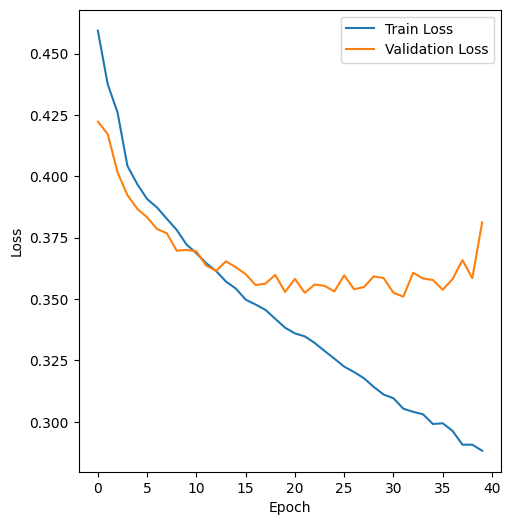

In [51]:
plt.figure(figsize=(12, 6))

# 1. 손실 시각화
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss'
plt.legend()

# 2. 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy') 
plt.plot(val_acc, label='Validation Accuracy') 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()  # 그래프 간격 조정
plt.show()  # 그래프 출력

In [53]:
save_path = os.path.join(save_dir, 'save_path.pth')
torch.save(model.state_dict(), save_path)

## Test & 결과 제출

In [54]:
def test(model, test_loader, threshold=0.5):
    outputs = []

    model.eval()
    with torch.no_grad():
        for image, w2v in tqdm(test_loader, desc='Test'):
            image, w2v = image.float().to(device), w2v.float().to(device)

            # Automatic Mixed Precision(AMP) 사용 (학습 속도, 메모리 절약)
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                output = model(image, w2v)

            output = output.detach().sigmoid()
            output = (output > threshold).long()  # threshold를 기준으로 0/1 판별
            outputs.append(output)

    outputs = torch.cat(outputs, dim=0).cpu().numpy()

    return outputs

In [55]:
from datetime import datetime

dt = datetime.now()
ctime = dt.strftime('%m%d_%H%M')  # 현재 월/일_시/분 확인

model = MovieClassifier(num_classes=num_classes, hidden_size=hidden_size)
model.load_state_dict(torch.load(save_path))  # state_dict 로드
model = model.to(device) 

threshold = 0.5
results = test(model, test_loader, threshold=threshold)

submission = pd.read_csv(root_dir + 'sample_submission.csv')
submission.iloc[:, 1:] = results
submission.to_csv(save_dir + f'submission_{ctime}.csv', index=False)

/tmp/ipykernel_23/1959490940.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))  # state_dict 로드
Test: 100%|██████████| 40/40 [

## 참고

### Confusion matrix 분석

Precision score : 0.5542168674698795
Recall score : 0.5419880034275921
F-score : 0.5480342250622766


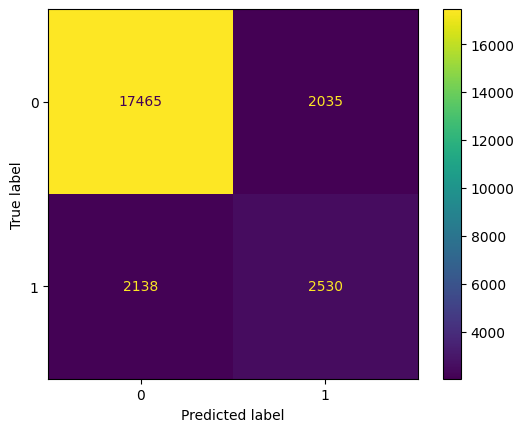

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay

outputs = []
v_loss = 0
tp, tn, fp, fn = 0, 0, 0, 0

model.eval()
with torch.no_grad():
    for image, w2v, label in val_loader:
        image, w2v, label = image.float().to(device), w2v.float().to(device), label.float().to(device)

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            output = model(image, w2v)
            loss = criterion(output, label)

        output = output.detach().sigmoid()
        output = (output > threshold).long()
        label, output = label.cpu(), output.cpu()

        mcm = multilabel_confusion_matrix(label, output, samplewise=True)
        outputs.append(mcm)

        v_loss += loss.cpu().item()

        tp += ((label == 1) & (output == 1)).float().sum()
        tn += ((label == 0) & (output == 0)).float().sum()
        fp += ((label == 0) & (label != output)).float().sum()
        fn += ((label == 1) & (label != output)).float().sum()

# 1. tp, tn, fp, fn을 직접 구하는 방법 
# precision = tp / (tp + fp)
# recall = tp / (tp + fn)
# f1 = 2 * (precision * recall) / (precision + recall)

# 2. confusion matrix의 결과를 바로 사용하는 방법 (tn, fp, fn, tp)
# cm = [[tn, fp],
#       [fn, tp]]

conf = np.sum(np.concatenate(outputs), axis=0)
precision = conf[1, 1] / (conf[1, 1] + conf[0, 1])
recall = conf[1, 1] / (conf[1, 1] + conf[1, 0])
f1 = 2 * (precision * recall) / (precision + recall)

print(f'Precision score : {precision}')
print(f'Recall score : {recall}')
print(f'F-score : {f1}')

disp = ConfusionMatrixDisplay(conf)
disp.plot()
plt.show()